In [1]:
import json, pickle
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

import torch
from torch.utils.data import DataLoader, TensorDataset

from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.providers.fake_provider import FakeSherbrooke

import matplotlib.pyplot as plt
import seaborn as sns

import importlib
import mlp
importlib.reload(mlp)
from mlp import encode_data_v2_ecr

In [2]:
fake_backend = FakeSherbrooke()

## Local
fake_backend_ideal = QasmSimulator() # Noiseless
fake_backend_noisy = AerSimulator.from_backend(fake_backend) # Noisy
stabilizer_simulator = AerSimulator(method='stabilizer')

fake_run_config_ideal = {'shots': 10000, 'backend': fake_backend_ideal, 'name': 'fake_ideal'}
fake_run_config_noisy = {'shots': 10000, 'backend': fake_backend_noisy, 'name': 'fake_noisy'}

In [3]:
import os
from tqdm.notebook import tqdm
def load_circuits(data_dir, f_ext='.json'):
    circuits = []
    ideal_exp_vals = []
    noisy_exp_vals = []
    Js = []
    data_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(f_ext)])
    for data_file in tqdm(data_files, leave=True):
        if f_ext == '.json':
            for entry in json.load(open(data_file, 'r')):
                circuits.append(QuantumCircuit.from_qasm_str(entry['circuit']))
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
        elif f_ext == '.pk':
            for entry in pickle.load(open(data_file, 'rb')):
                circuits.append(entry['circuit'])
                Js.append(entry['J'])
                # ideal_exp_vals.append(entry['ideal_exp_value'])
                # noisy_exp_vals.append(entry['noisy_exp_values'])
    return circuits, Js #, ideal_exp_vals, noisy_exp_vals

circuits, Js = load_circuits('./data/ising_zne_hardware/100q_sherbrooke_sameJ_h0.66pi/', '.pk')

  0%|          | 0/10 [00:00<?, ?it/s]

In [4]:
with open('./zne_mitigated/100q_sherbrooke_30persteps_shots1w_sameJ.pk', 'rb') as file:
    loaded = pickle.load(file)
zne_mitigated_vals = loaded['mitigated_vals']
noisy_vals = loaded['noisy_vals']

In [5]:
print(len(circuits), len(zne_mitigated_vals), len(noisy_vals))

300 300 300


In [6]:
num_circ_per_step = 30
k = train_test_split = 25
train_circuits = []
train_zne_vals = []
train_noisy_vals = []
test_circuits = []
test_zne_vals = []
test_noisy_vals = []
for start_each_step in list(range(len(circuits))[::num_circ_per_step]):
    train_circuits += circuits[start_each_step:start_each_step+k]
    train_zne_vals += zne_mitigated_vals[start_each_step:start_each_step+k]
    train_noisy_vals += noisy_vals[start_each_step:start_each_step+k]
    test_circuits += circuits[start_each_step+k:start_each_step+num_circ_per_step]
    test_zne_vals += zne_mitigated_vals[start_each_step+k:start_each_step+num_circ_per_step]
    test_noisy_vals += noisy_vals[start_each_step+k:start_each_step+num_circ_per_step]

In [7]:
print(len(train_circuits), len(train_zne_vals), len(train_noisy_vals))
print(len(test_circuits), len(test_zne_vals), len(test_noisy_vals))

250 250 250
50 50 50


In [8]:
X_train, y_train = encode_data_v2_ecr(train_circuits, train_zne_vals, train_noisy_vals, obs_size=5)
X_test, y_test = encode_data_v2_ecr(test_circuits, test_zne_vals, test_noisy_vals, obs_size=5)

In [9]:
print(X_train.shape, y_train.shape)

torch.Size([250, 170]) torch.Size([250, 5])


In [14]:
BATCH_SIZE = 32
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*1000, shuffle=False)

In [15]:
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)

In [16]:
from sklearn.ensemble import RandomForestRegressor
rfr_tree_list = []
for q in range(5):
    rfr = RandomForestRegressor(n_estimators=100)
    rfr.fit(X_train, y_train.iloc[:, q])
    rfr_tree_list.append(rfr)

RMSE_noisy_0: 0.1271486801729347
RMSE_mitigated_0: 0.052740543523657896
RMSE_noisy_1: 0.11345771643412483
RMSE_mitigated_1: 0.045997868599469284
RMSE_noisy_2: 0.09236910053578297
RMSE_mitigated_2: 0.04746221716255397
RMSE_noisy_3: 0.04359941972497227
RMSE_mitigated_3: 0.01937512565056798
RMSE_noisy_4: 0.08604729393305179
RMSE_mitigated_4: 0.021871156701627325
RMSE_noisy: 0.09933831136866253
RMSE_mitigated: 0.04337460777582209


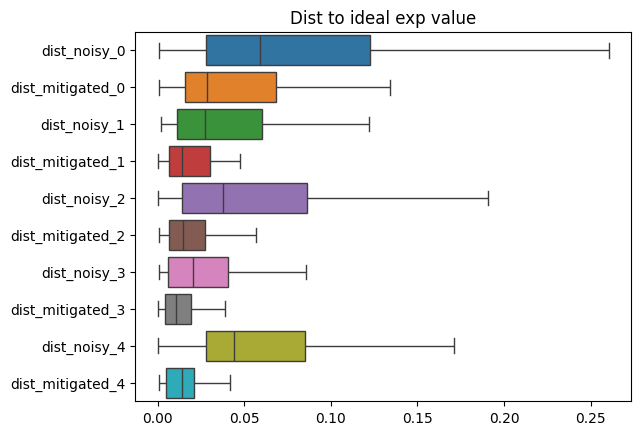

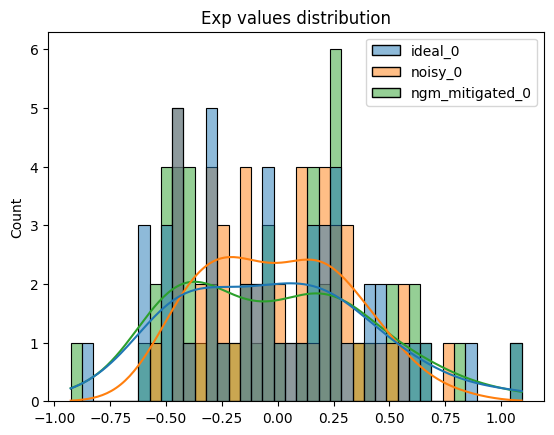

In [17]:
distances = []

num_spins = 5

for batch_X, batch_y in test_loader:
    out = []
    for q, model in enumerate(rfr_tree_list):
        out.append(model.predict(batch_X[:, :]))
    out = np.array(out).transpose()

    for ideal, noisy, ngm_mitigated in zip(
        batch_y.tolist(),
        batch_X[:, -5:].tolist(),
        out.tolist()
    ):
        for q in range(5):
            ideal_q = ideal[q]
            noisy_q = noisy[q]
            ngm_mitigated_q = ngm_mitigated[q]
            distances.append({
                f"ideal_{q}": ideal_q,
                f"noisy_{q}": noisy_q,
                f"ngm_mitigated_{q}": ngm_mitigated_q,
                f"dist_noisy_{q}": np.abs(ideal_q - noisy_q),
                f"dist_mitigated_{q}": np.abs(ideal_q - ngm_mitigated_q),
                f"dist_sq_noisy_{q}": np.square(ideal_q - noisy_q),
                f"dist_sq_mitigated_{q}": np.square(ideal_q - ngm_mitigated_q),
            })

plt.style.use({'figure.facecolor':'white'})

df = pd.DataFrame(distances)

for q in range(5):
    print(f'RMSE_noisy_{q}:', np.sqrt(df[f"dist_sq_noisy_{q}"].mean()))
    print(f'RMSE_mitigated_{q}:', np.sqrt(df[f"dist_sq_mitigated_{q}"].mean()))

print(f'RMSE_noisy:', np.sqrt(np.mean([df[f"dist_sq_noisy_{q}"].mean() for q in range(4)])))
print(f'RMSE_mitigated:', np.sqrt(np.mean([df[f"dist_sq_mitigated_{q}"].mean() for q in range(4)])))

sns.boxplot(data=df[["dist_noisy_0", "dist_mitigated_0", "dist_noisy_1", "dist_mitigated_1", "dist_noisy_2", "dist_mitigated_2", "dist_noisy_3", "dist_mitigated_3", "dist_noisy_4", "dist_mitigated_4"]], orient="h", showfliers = False)
plt.title("Dist to ideal exp value")
plt.show()

sns.histplot([df['ideal_0'], df['noisy_0'], df["ngm_mitigated_0"]], kde=True, bins=40)
plt.title("Exp values distribution")
plt.show()

In [116]:
with open('./model/mimic_zne_hardware/100q_rfr_list.pk', 'wb') as f:
    pickle.dump(rfr_tree_list, f)